## CREAZIONE DELL'AMBIENTE DI LAVORO

#### ACQUISIZIONE DEL DATASET

In [10]:
import os

# NB: come scritto nel readme questa parte non è fondamentale se ci sono gia' i file
# necessari nella cartella /data/

# Cambiare le credenziali kaggle per poter scaricare i dati
# Si uncommenti e si cambino le stringhe con le proprie credenziali
# os.environ['KAGGLE_USERNAME'] = "your_username"
# os.environ['KAGGLE_KEY'] = "your_password"

# Download di tutti i file .csv presenti nel dataset di instgram
!kaggle datasets download -p ./data -d bhanupratapbiswas/instgram --unzip 

Dataset URL: https://www.kaggle.com/datasets/bhanupratapbiswas/instgram
License(s): ODC Public Domain Dedication and Licence (PDDL)
100%|█████████████████████████████████████████| 151k/151k [00:00<00:00, 523kB/s]
100%|█████████████████████████████████████████| 151k/151k [00:00<00:00, 521kB/s]


#### CONTAINER NEO4J


Per fare il build e lo start del container di neo4j (si parte dalla empty sandbox) si deve far girare nella cartella del progetto contente `docker-compose.yml` il comando riportato di seguito.
```bash
sudo docker-compose up
```

**NB**: Nell'ambiente di visual studio non si riesce, purtroppo, a far girare comandi di questo tipo in modo interattivo (nessuna possibilità di immettere la password).
Si e' anche valutato se mettere la password in un file .env e richiamarla da riga di comando ma non sarebbe stata sicura. Per questo si richiede all'utente di immeterlo da terminale.

Prima di continuare aspettare la conferma dell'avvio del container, come in figura:
![container neo4j](media/container_start.png)

#### CONNESSIONE AL DATABASE

In [1]:
from neo4j import GraphDatabase as gd

# Prima di arrivare a questo punto si controlli di aver correttamente attivato il container
# Nel caso in cui ci siano dubbi su ip/porta da usare si controlli nel log docker alla voce "bolt"
URI = "bolt://localhost:7688" 

d   = gd.driver(URI, auth=None)
d.verify_connectivity()


#### CREAZIONE DATABASE

In [2]:
s   = d.session()

# Prova a creare un nuovo database vuoto col nome di instagram
# Che ci fosse gia' o meno alla fine setta la sessione sul database instagram
# Lo si fa all'inizio per non dover specificare ogni volta su che database fare le query
try:
    s.run("create database instagram").data() 
except: 
    s = d.session(database="instagram")
finally:
    s = d.session(database="instagram")

In [3]:
# La creazione dei constraint viene fatta per ogni nodo che sara' presente
# I constraint in questione specificano tutti l'unicita' dell'ID per ogni nodo
s.run("create constraint UniqueUserID if not exists for (u:User) require u.id is unique;")
s.run("create constraint UniqueCommentID if not exists for (c:Comment) require c.id is unique;")
s.run("create constraint UniquePostID if not exists for (p:Post) require p.id is unique;")
s.run("create constraint UniqueTagID if not exists for (t:Tag) require t.id is unique;")

# Nel caso in cui il constraint esista gia' non verrà creato nessun errore grazie a 'if not exists'


Accedendo a http://localhost:7474 e poi con nessuna autenticazione a bolt://localhost:7688 si può:
* controllare che esiste il database instagram
    ```cypher 
    :dbs
* entrare nel database
    ```cypher
    :use instagram
* controllare che siano stati aggiunti i quattro constraint
    ```cypher
    :schema

In [4]:
# Si è fatto un test per essere sicuri di come e dove trovare tutti i csv
# La stampa ritorna il numero di righe del file (8782)
res = s.run('''load csv with headers
                from 'file:///likes.csv' as line
                return count(line)''').data()
print(res)

[{'count(line)': 8782}]


#### AGGIUNTA NODI

In [5]:
# Si e' notato che le date di creazione di tag, commenti e foto sono tutte fabbricate
# lo stesso giorno
# Si e' deciso quindi di non usarle in quanto di poca utilita'

# Per i nodi user non vengono messe le properties 'post count' 
# e 'verified status' in quanto la prima si puo' ricavare e la seconda 
# non sembra importante per le analisi che si faranno
s.run('''load csv with headers
         from 'file:///users.csv' as row
         with row merge (u:User{id:toInteger(row.id)})
         on create set
            u.name = row.name,
            u.created = toString(row.`created time`), 
            u.type = toString(row.`private/public`)''')

s.run('''load csv with headers from 'file:///tags.csv' as row 
         with row merge (t:Tag{id:toInteger(row.id)}) 
         on create set 
            t.text = toString(row.`tag text`), 
            t.location = toString(row.location) ''')

# Per le foto non vengono caricati i link in quanto non servono per l'analisi che si fara'
s.run('''load csv with headers from 'file:///photos.csv' as row 
         with row merge (p:Post{id:toInteger(row.id)}) 
         on create set
            p.filter = toString(row.`Insta filter used`),
            p.type = toString(row.`photo type`) ''')


s.run('''load csv with headers from 'file:///comments.csv' as row 
         with row merge (c:Comment{id:toInteger(row.id)}) 
         on create set
            c.text = toString(row.comment) ''')

#### AGGIUNTA RELAZIONI

In [6]:
# Relazione di creazione post da parte dello user
s.run('''load csv with headers from 'file:///photos.csv' as row 
         match (p:Post{id:toInteger(row.id)})
         match (u:User{id:toInteger(row.`user ID`)}) 
         merge (p)<-[:POSTED]-(u) ''') 

# Relazione di un tag contenuto in un post
# La relazione tra tag e user può essere ricavata da user -> post -> tag
s.run('''load csv with headers from 'file:///photo_tags.csv' as row 
         match (p:Post{id:toInteger(row.photo)})
         match (t:Tag{id:toInteger(row.`tag ID`)}) 
         merge (p)-[:HAS_TAG]->(t) ''') 

# Relazione di un like di uno user su un post
# Anche in questo caso il 'created time' e' stato fabbricato e non viene quindi preso in considerazione
# La properties 'following or not' si può invece ricavare e non viene quindi settata
s.run('''load csv with headers from 'file:///likes.csv' as row 
         match (p:Post{id:toInteger(row.photo)})
         match (u:User{id:toInteger(row.`user `)}) 
         merge (p)<-[:LIKE {type: row.`like type`}]-(u) ''') 

# Relazione di follow tra user
# Anche in questo caso le properties 'is follower active' e 'followee Acc status' non sono fondamentali
# e possono essere ricavate dalle varie relazioni e properties gia' salvate
s.run('''load csv with headers from 'file:///follows.csv' as row 
         match (a:User{id:toInteger(row.follower)})
         match (b:User{id:toInteger(row.`followee `)}) 
         merge (a)-[:FOLLOWS]->(b) ''') 

# Relazione di un commento sotto un post
s.run('''load csv with headers from 'file:///comments.csv' as row 
         match (c:Comment{id:toInteger(row.id)})
         match (p:Post{id:toInteger(row.`Photo id`)}) 
         merge (p)<-[:COMMENT_ON]-(c) ''') 

# Relazione di uno user che crea un commento
s.run('''load csv with headers from 'file:///comments.csv' as row 
         match (c:Comment{id:toInteger(row.id)})
         match (u:User{id:toInteger(row.`User  id`)}) 
         merge (c)-[:COMMENTED_BY]->(u) ''') 


#### AGGIUNTA INDICI

In [8]:
# Si sceglie di creare dei text index per un po' tutte le proprieta' dei nodi
# questo perchè tutti i campi sono in formato di stringa e non si pensa di aver mai 
# bisogno di alzare le performance di operazioni numeriche (range indexes)
s.run('''create text index for (u:User) on (u.name)''')
s.run('''create text index for (u:User) on (u.type)''')

s.run('''create text index for (t:Tag) on (t.text)''')
s.run('''create text index for (t:Tag) on (t.location)''')

s.run('''create text index for (p:Post) on (p.type)''')

s.run('''create text index for (c:Comment) on (c.text)''')

# Gli id sono fatti invece di default dai constraint di unicita'

ClientError: {code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent index already exists, 'Index( id=11, name='index_8ed67dd1', type='TEXT', schema=(:User {name}), indexProvider='text-2.0' )'.}

## EXPLORATORY DATA ANALYSIS

Per visionare lo schema generale del nostro grafo appena creato si puo' lanciare il comando:
```cypher
call db.schema.visualization()
```

Il risultato di questa operazione dovrebbe essere:

![graph](media/graph_schema.png)

<Axes: ylabel='count'>

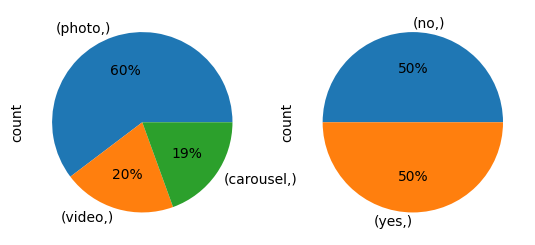

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
a = plt.subplots(nrows=1, ncols=2)[1]

res = s.run('''match (p:Post) return p.type''').data()
pd.DataFrame(res).value_counts().plot(ax=a[0], y="type", kind="pie", autopct='%1.0f%%')

res = s.run('''match (u:User) return u.type''').data()
pd.DataFrame(res).value_counts().plot(ax=a[1], y="type", kind="pie", autopct='%1.0f%%')

# Si nota come per i post sia piu' ricorrente fare foto rispetto a video e carousel
# questo potrebbe essere dato dal fatto che sono gli utenti piu' attivi generano tanti 
# tipi di contenuti mentre quelli meno attivi generano quasi solo foto.

# Per la tipologia di utente (yes=private, no=public) non vi è alcuna differenza
# da notare come non viene spiegato perfettamente il significato di yes/no 
# ma si interpreta come private/public (nome proprietà) = yes/no.

<Axes: ylabel='count'>

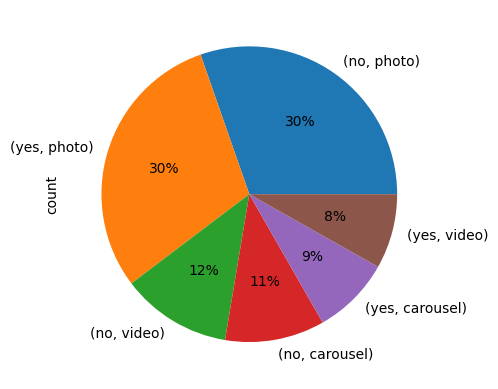

In [12]:
# Proviamo a dare una risposta all'ipotesi avanzata nel precedente commento
res = s.run('''match (p:Post)<-[:POSTED]-(u:User) 
            return u.type as user_type, p.type as post_type''').data()

pd.DataFrame(res).value_counts().plot(y="post_type", kind="pie", autopct='%1.0f%%')

# Come si può vedere dalla torta il numero di foto create da utenti privati e non è in ugual misura
# Per quanto riguarda invece i contenuti sia video che reel la percentuale è maggiore
# per utenti pubblici che privati 

<Axes: ylabel='count'>

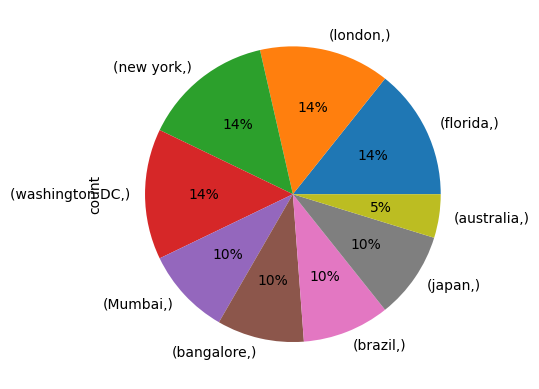

In [19]:
# Per completare la visualizzazione della moda delle properties piu' importanti
# aggiungiamo il grafico sulle percentuali delle location taggate
res = s.run('''match (t:Tag) return t.location''').data()
pd.DataFrame(res).value_counts().plot(y="location", kind="pie", autopct='%1.0f%%')

Quello che si potrebbe provare a estrapolare da questi ultimi dati è che il dataset rispecchia in piccola parte i veri dati di instagram dei post per continente.
Questa teoria viene in parte provata da alcuni dei grafici di questo [studio](https://mention.com/en/reports/instagram/instagram-report-location/).
Il numero di post maggiori e' dato da regioni USA e questo spiega come mai NYC, Florida e Washington siano 
ad una percentuale cosi alta. Queste regioni vengono seguite dal Brasile per cui prova anche la seconda 
percentuale migliore da parte del Brasile.
Altro dato interessante e' quello che prova la posizione cosi alta anche di Londra, essa e' la citta' con 
maggior numero di post anche prima di NYC. E prima anche tra le citta' inglesi come numero di post.
Inoltre si può notare come i continenti di Asia e Oceania hanno valori molto bassi rispetto a tutti gli altri, questo spiega come mai Australia abbia la percentuale minore. Non spiega come mai Giappone sia a parimerito con Brasile che abbiamo detto essere la seconda country per numero di post.
Infine si noti come la citta' con piu' alto tasso di interazione è stata Mumbai che verosimilmente occupa
la seconda percentuale migliore nel nostro grafico.
L'unico dato che non si riesce bene a ricostruire sembra quindi essere Bangalore.

 
Sfortunatamente non si può fare una reale predizione in quanto il dataset usato non è sicuramente completo di tutti i dati di Instagram.

          tipo  min  max    average      stdev
0         clap   13   52  22.779221  13.075312
1   double tap    2   10   6.000000   5.656854
2         fire   14   52  22.740260  13.194300
3  heart emoji   14   52  22.740260  12.996358
4     laughing   14   52  22.740260  13.054947
5   single tap    2   10   6.000000   5.656854
6    thumbs up   14   52  22.740260  12.996358


<Axes: >

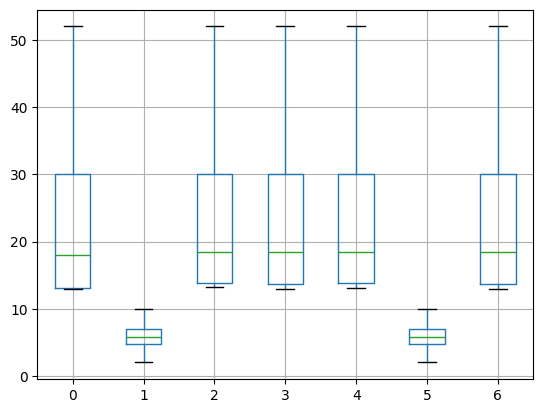

In [36]:
# Continuando con l'esplorazione dei dati cerchiamo di capire come solitamente 
# uno user reagisce ad un post (tipo di emoji usato)
res = s.run('''match (u:User)-[r:LIKE]->() with r.type as tipo, u, count(*) as degree
         return tipo, min(degree) as min, max(degree) as max, 
         avg(degree) as average, stdev(degree) as stdev order by tipo''').data()
df = pd.DataFrame(res)
print(df)

df.drop(columns='tipo').T.boxplot()

# Come ci si aspettava thumbs up, heart, fire e laughing emoji sono quelli piu' gettonati 
# con nessuno pero' migliore dell'altro
# Come si nota dal grafico double tap e single tap (1, 5) sono abbastanza simmetriche mentre le altre
# distribuzioni sono positivamente skew

array([[<Axes: title={'center': 'outdegree'}>]], dtype=object)

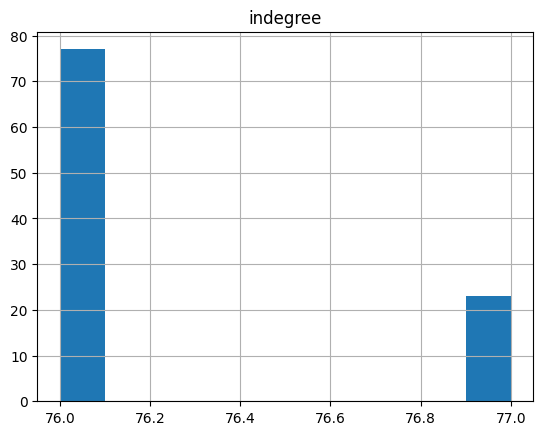

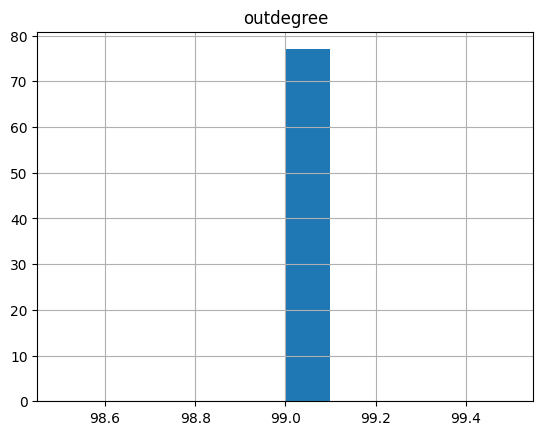

In [53]:
# Controlliamo ora come sono distribuiti il numero di follower per user (in degree)
res = s.run('''match (u:User)<-[:FOLLOWS]-() with distinct u.id as user, 
               count(*) as indegree return indegree''').data()

pd.DataFrame(res).hist()

# I valori sembrano tutti molto vicini tra loro ma, come si vede per range di valori piu' ampi
# su social network graph, riporta molti utenti con valori piu' bassi e pochi con valori alti
# Si potrebbe avanzare quindi l'ipotesi che gli utenti con valore nell'intorno di 76.9-77.0 
# siano quelli piu' seguiti

# Controlliamo ora com'e' distribuito il numero di persone seguite per user (out degree)
res = s.run('''match (u:User)-[:FOLLOWS]->() with distinct u.id as user, 
               count(*) as outdegree return outdegree''').data()

pd.DataFrame(res).hist()
# Quello che si sperava di trovare e' un grafo circa come quello precedente in quanto
# specularmente a prima gli utenti piu' seguiti sono quelli che dovrebbe seguire meno
# Il fatto che e' stato trovato questo risultato fa pensare che il grafo possa non rappresentare
# appieno uno small-world come invece sarebbero social di questo tipo

In [13]:
# Nonostante alcune imperfezioni del dataset controlliamo che esistano delle comunita'
# Per avere performance migliori durante le nostre ricerche creaiamo prima una proiezione
# In questo caso ci servono gli utenti e la relazione di following
# Per una semplice vista di questo tipo possiamo usare una native projection in cui consideriamo 
# solamente nodi utente e relazione di seguace-seguito.
s.run('''call gds.graph.project('follows', 'User', 'FOLLOWS')''')

res = s.run('''call gds.labelPropagation.stream('follows') yield  nodeId as n, communityId as c 
         return distinct c, count(*)''').data()

print(res)



[{'c': 0, 'count(*)': 78}, {'c': 6, 'count(*)': 1}, {'c': 22, 'count(*)': 1}, {'c': 24, 'count(*)': 1}, {'c': 28, 'count(*)': 1}, {'c': 33, 'count(*)': 1}, {'c': 44, 'count(*)': 1}, {'c': 48, 'count(*)': 1}, {'c': 50, 'count(*)': 1}, {'c': 52, 'count(*)': 1}, {'c': 57, 'count(*)': 1}, {'c': 58, 'count(*)': 1}, {'c': 63, 'count(*)': 1}, {'c': 67, 'count(*)': 1}, {'c': 73, 'count(*)': 1}, {'c': 76, 'count(*)': 1}, {'c': 79, 'count(*)': 1}, {'c': 80, 'count(*)': 1}, {'c': 82, 'count(*)': 1}, {'c': 85, 'count(*)': 1}, {'c': 87, 'count(*)': 1}, {'c': 88, 'count(*)': 1}, {'c': 89, 'count(*)': 1}]


Volendo si può anche provare un'alternativa alla native projection che è la cypher (ma in questo caso sarebbe molto meno performante):
```python
s.run('''call gds.graph.project.cypher      
    ('follow', 
    'match (u:User) return u.id as id', 
    'match (a:User)-[r:FOLLOWS]-(b:User)
    return distinct a.id as source, 
    b.id as target, type(r) as type') ''')
```

Come si era predetto dai risultati 'strani' del grafico degli outdegree notiamo che viene segnalata una comunita' molto grande e tutte le altre 22 con un solo individuo.
Cio' probabilmente vuol dire che ci troviamo in presenza di un grafico molto connesso in cui la maggior parte degli utenti e' connessa con l'altra.
Questo è verosimilmente provato dal fatto che usando l'algoritmo di pagerank tutti i nodi hanno valore di score praticamente uguale (0.43) e che la differenza si nota solo dopo la terza cifra decimale: i nodi della comunita' piu' grande hanno valore 0.431 mentre i restanti hanno un 0.435.
Per controllare si può lanciare:
1.  ```cypher 
    call gds.pageRank.stream('follows') 
    yield nodeId, score
    return distinct score AS Score, count(*)
2. ```python 
    res = s.run('''call gds.pageRank.stream('follows') yield nodeId, score return distinct score as Score, count(*)''').data()

    print(res)


In [63]:
# Per provare l'ipotesi precedente formulata guardiamo quindil'effective diameter
# Che è il maggiore degli shortestpath.
# Si sceglie di mettere un massimo alla lunghezza in quanto se fosse uno small-world 
# tipicamente non si hanno path > 5, se fosse un grafo completo il numero sarebbe 1.
# Ricordiamo che il grafo in questione non e' pesato e che quindi ogni arco ha peso 1.
res = s.run('''match (a:User)-[r]-(b:User) where a.id < b.id
               match p = shortestPath((a)-[*..10]-(b))
               return length(p) as diameter order by diameter desc limit 1''').data()
print(res)
# Altra prova che il grafo non è uno small-world

[{'diameter': 1}]


## RESEARCH QUESTIONS

#### PREDIZIONE DI UNO USER IN VACANZA

Questa domanda si pensa possa essere utile per due motivi:

* Si vuole far capire l'importanza di non lasciare in rete alcune informazioni (anche implicite) in quanto in questo caso utenti maligni potrebbero usarle a proprio favore. In questo caso si pensi a come una banda di ladri potrebbe usare l'informazione per andare a svaligiare casa sapendo dove abita/abitano la/e vittima/e e che questa/i siano in vacanza.

* Capire se anche con la sola informazione della location si possono consigliare eventuali posti da visitare o in cui comprare.

Inanzitutto si ragiona con che dati si potrebbe risolvere la domanda.
Con la semplice location si potrebbe ipotizzare che basti sapere il numero di post di un utente per una data regione. Se la percentuale di una location e' maggiore di una certa soglia e lo user ha postato molti contenuti allora una con percentuale minore ha piu' chance di essere stata fatta durante una vacanza.
Per utenti non soliti a postare possiamo dire (ovviamente molto meno) in quanto ogni foto potrebbe essere di una vacanza.

In [10]:
# Si decide di creare una proiezione con gli user e i tag (i quali hanno al loro interno la proprieta'
# location).
# La projection sara' di tipo cypher in quanto vogliamo modellare qualcosa di piu' complesso
# rispetto a prendere tutti nodi user e tutti nodi tag.
s.run('''match (source:User)-[:POSTED]->()-[]->(target:Tag)
         with gds.graph.project('locations', source, target) as g
         return g.graphName, g.nodeCount, g.relationshipCount''')

res = s.run('''call gds.''').data()

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Unknown function 'gds.graphs.project.cypher' (line 2, column 15 (offset: 65))
"         with gds.graphs.project.cypher('locations', source, target) as g"
               ^}

Per controllare che la proiezione sia stata creata si può lanciare:
```cypher
call gds.graph.list()
```
**NB**: L'operazione da un warning se eseguita da browser in quanto funzione deprecata, si è stati costretti ad usarla perchè non sono state trovate tecniche alternative per poter visionare tutte le proiezioni. Inoltre nella pagina di [documentazione](https://neo4j.com/docs/graph-data-science/current/operations-reference/graph-operation-references/) non sembra essere riportata una funzione aggiuntiva.

## CHIUSURA SESSIONE

In [20]:
s.close()
d.close()